# Data science capstone project : Neighbourhood battle of Four Cities

## Despite the distinct culture and geographcial location differences of New York, Toronto, Beijing and Shanghai, I'm tring to search for similar neighborhoods among these cities.

## Let's start with importing necessary libraries.


In [185]:
# import necessary packages
import numpy as np
import pandas as pd 
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium # map rendering library
from bs4 import BeautifulSoup
from geopy.exc import GeocoderTimedOut

print('Libraries imported.')


Libraries imported.


In [186]:
# obtain New York neighborhood data
with open('new_york.json') as json_data:
    newyork_data = json.load(json_data)
    
nyneighborhoods = newyork_data['features']

# define the dataframe with four columns: City, Borough, Neighborhood, Latitude, Longitude
column_names = ['City','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyneighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'City': 'New York',
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [187]:
#Define a function to plot the city map with different neighborhood labels based on Borough
def citymap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighborhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

In [188]:
citymap('New York','USA',ny_neighborhoods)

## We see that all the neighorhoods in the same Borough fall into the same color and are well seprated in map, indicating good quality of data.
# Now Let's look at neighborhoods in Toronto:

In [189]:
# obtain Toronto neighborhood data
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wikipage = requests.get(url)
wikipage.text[:100]

#Create a new pd DataFrame
toronto = pd.DataFrame()

#use beautifulsoup to read the wikipage
soup = BeautifulSoup(wikipage.text, 'lxml')
wikitable = soup.find_all('table')[0] 

row_marker = 0

for row in wikitable.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        toronto.loc[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

#rename column names
toronto.rename(columns={0:'PostalCode',1:'Borough',2:'Neighborhood'}, inplace=True)
#drop all rows with unassigned borough
toronto = toronto[toronto.Borough!='Not assigned']
toronto.reset_index(drop=True,inplace=True)

#create a new dataframe toronto_neighbor to find all neighborhoods with the location information
toronto_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

geolocator = Nominatim(user_agent="capstone-proj")
    
def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

for ii in range(toronto.shape[0]):
    borough = toronto.loc[ii,'Borough']
    postalcode = toronto.loc[ii,'PostalCode']
    neighborhood = toronto.loc[ii,'Neighborhood'][:-1] #delete the last character \n
    
    #if the neighborhood name is not assigned, than the neighorhood name is same as borough
    if neighborhood == 'Not assigned':
        neighborhood = borough
    
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    location = do_geocode("{},{},Toronto,Ontario,Canada".format(neighborhood,borough))
    
    #try one more searching
    #if location is None: 
    #    location = do_geocode("{},Toronto,Ontario,Canada".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        toronto_neighborhoods = toronto_neighborhoods.append({'City': 'Toronto',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

toronto_neighborhoods.head()

The location data of Harbourfront in Downtown Toronto is not available!
The location data of Regent Park in Downtown Toronto is not available!
The location data of Parkview Hill in East York is not available!
The location data of Humewood-Cedarvale in York is not available!
The location data of Berczy Park in Downtown Toronto is not available!
The location data of Caledonia-Fairbanks in York is not available!
The location data of Adelaide in Downtown Toronto is not available!
The location data of Harbourfront East in Downtown Toronto is not available!
The location data of Toronto Islands in Downtown Toronto is not available!
The location data of CFB Toronto in North York is not available!
The location data of Design Exchange in Downtown Toronto is not available!
The location data of Toronto Dominion Centre in Downtown Toronto is not available!
The location data of India Bazaar in East Toronto is not available!
The location data of Commerce Court in Downtown Toronto is not available!
Th

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.761124,-79.324059
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,North York,Lawrence Heights,43.722778,-79.450933
3,Toronto,North York,Lawrence Manor,43.722079,-79.437507
4,Toronto,Queen's Park,Queen's Park,43.660020,-79.390787


In [190]:
citymap('Toronto','Canada',toronto_neighborhoods)

## By looking at the map carefully, there are three outliers jump into downtown area: Queen's Park, Trinity and North Toronto West, which is caused by the mismatch in geocoder. Let's clean it:

In [191]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Queen\'s Park']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Trinity']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'North Toronto West']
toronto_neighborhoods.reset_index(drop=True,inplace=True)
toronto_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.761124,-79.324059
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,North York,Lawrence Heights,43.722778,-79.450933
3,Toronto,North York,Lawrence Manor,43.722079,-79.437507
4,Toronto,Etobicoke,Islington Avenue,43.645647,-79.523975


# Let's plot the map of Toronto again

In [192]:
citymap('Toronto','Canada',toronto_neighborhoods)

# It looks clean now. Let's look at Beijing and Shanghai.

In [193]:
# read the csv file extracted from Wikipedia including the Districts and Subdisctricts
bj = pd.read_csv('Beijing.csv')
bj.rename(columns={'District':'Borough','Subdisctricts':'Neighborhood'}, inplace=True)
bj.head()

,City,Borough,Neighborhood
0,Beijing,Changping,Chengbei
1,Beijing,Changping,Chengnan
2,Beijing,Changping,Huilongguan
3,Beijing,Changping,Longzeyuan
4,Beijing,Changping,Shigezhuang


In [194]:
#create a new dataframe bj_neighbor to find all neighborhoods with the location information
bj_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for ii in range(bj.shape[0]):
    borough = bj.loc[ii,'Borough']
    neighborhood = bj.loc[ii,'Neighborhood']
      
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    location = do_geocode("{},{},Beijing,China".format(neighborhood,borough))
    
    #try one more searching
    #if location is None: 
    #    location = do_geocode("{},Beijing,China".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        bj_neighborhoods = bj_neighborhoods.append({'City': 'Beijing',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

bj_neighborhoods.head()

The location data of Chengbei in Changping is not available!
The location data of Chengnan in Changping is not available!
The location data of Longzeyuan in Changping is not available!
The location data of Shigezhuang in Changping is not available!
The location data of Tiantongyuanbei in Changping is not available!
The location data of Nankou in Changping is not available!
The location data of Machikou in Changping is not available!
The location data of Dongxiaokou in Changping is not available!
The location data of Xiaotangshan in Changping is not available!
The location data of Cuicun in Changping is not available!
The location data of Baishan in Changping is not available!
The location data of Beiqijia in Changping is not available!
The location data of Xingshou in Changping is not available!
The location data of Liucun in Changping is not available!
The location data of Shasanling in Changping is not available!
The location data of Yanshou in Changping is not available!
The locatio

,City,Borough,Neighborhood,Latitude,Longitude
0,Beijing,Changping,Huilongguan,40.069525,116.329755
1,Beijing,Changping,Tiantongyuannan,40.065123,116.406506
2,Beijing,Changping,Huoying,40.069357,116.354448
3,Beijing,Changping,Shahe,40.147044,116.282768
4,Beijing,Changping,Yangfang,40.138543,116.138360


In [195]:
bj_neighborhoods.shape

(190, 5)

## A number of neighborhoods don't have location data. But anyway, there are more than 200 neighborhoods with valid location data, enough for my analysis. Show these neighborhoods on map:

In [196]:
citymap('Beijing','China',bj_neighborhoods)

## Some nerghborhoods doesn't lie into their boroughs (wrong location data). Let's clean it out.

In [197]:
drop = ['Xiangyang','Shilipu','Jiuxian','Binhe','Xincun','Yongding','Shiyuan','Dayu','Shuguang','Guangning','Beiwu',
       'Dongfeng','Guangming','Liucun','Nankou']

for neighborhoods in drop:
    bj_neighborhoods = bj_neighborhoods[bj_neighborhoods.Neighborhood != neighborhoods]
    bj_neighborhoods.reset_index(drop=True,inplace=True)
    
bj_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Beijing,Changping,Huilongguan,40.069525,116.329755
1,Beijing,Changping,Tiantongyuannan,40.065123,116.406506
2,Beijing,Changping,Huoying,40.069357,116.354448
3,Beijing,Changping,Shahe,40.147044,116.282768
4,Beijing,Changping,Yangfang,40.138543,116.138360


In [198]:
citymap('Beijing','China',bj_neighborhoods)

## repeat the same process for Shanghai

In [199]:
# read the csv file extracted from Wikipedia including the Districts and Subdisctricts
sh = pd.read_csv('Shanghai.csv')
sh.rename(columns={'District':'Borough','Subdistrict':'Neighborhood'}, inplace=True)
sh.head()

,City,Borough,Neighborhood
0,Shanghai,Baoshan,Wusong
1,Shanghai,Baoshan,Youyi
2,Shanghai,Baoshan,Zhangmiao
3,Shanghai,Baoshan,Dachang
4,Shanghai,Baoshan,Gaojing


In [200]:
#create a new dataframe sh_neighbor to find all neighborhoods with the location information
sh_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for borough, neighborhood in zip(sh['Borough'],sh['Neighborhood']):   
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    location = do_geocode("{},{},Shanghai,China".format(neighborhood,borough))
    
    #try one more searching
    #if location is None: 
    #    location = g("{},Shanghai,China".format(neighborhood),timeout=None)
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        sh_neighborhoods = sh_neighborhoods.append({'City': 'Shanghai',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

sh_neighborhoods.head()

The location data of Miaohang in Baoshan is not available!
The location data of Xianhua in Changning is not available!
The location data of Zhoujiaqiao in Changning is not available!
The location data of Shanghai Fengxian Bay Tourism Zone in Fengxian is not available!
The location data of Shanghai Seaport Comprehensive Economic Development Zone in Fengxian is not available!
The location data of Jiangwanzhen in Hongkou is not available!
The location data of Ruijin Second Road in Huangpu is not available!
The location data of Xiaodongmen in Huangpu is not available!
The location data of Jiadingzhen in Jiading is not available!
The location data of Juyuan New Area Administrative Committee in Jiading is not available!
The location data of Zhenxin in Jiading is not available!
The location data of Huating in Jiading is not available!
The location data of Waigang in Jiading is not available!
The location data of Xuhang in Jiading is not available!
The location data of Beizhan in Jingan is not

,City,Borough,Neighborhood,Latitude,Longitude
0,Shanghai,Baoshan,Wusong,31.374707,121.489410
1,Shanghai,Baoshan,Youyi,31.405927,121.471382
2,Shanghai,Baoshan,Zhangmiao,31.335766,121.440917
3,Shanghai,Baoshan,Dachang,31.294144,121.412396
4,Shanghai,Baoshan,Gaojing,31.323159,121.477525


In [201]:
citymap('Shanghai','China',sh_neighborhoods)

In [202]:
drop = ['Chenjia','Xinhe','Xincun','Zhongxing','Changzheng','Beizhan','Chaoyang Farm']

for neighborhoods in drop:
    sh_neighborhoods = sh_neighborhoods[sh_neighborhoods.Neighborhood != neighborhoods]
    sh_neighborhoods.reset_index(drop=True,inplace=True)
    
citymap('Shanghai','China',sh_neighborhoods)

In [203]:
# save the data
ny_neighborhoods.to_csv('ny_neighborhoods.csv', sep='\t')
toronto_neighborhoods.to_csv('toronto_neighborhoods.csv', sep='\t')
bj_neighborhoods.to_csv('bj_neighborhoods.csv', sep='\t')
sh_neighborhoods.to_csv('sh_neighborhoods.csv', sep='\t')

In [213]:
#Use Foursquare to expore the neighborhoods
#My Foursquare Credentials 
CLIENT_ID = 'EJDT2KV1H23FGHSXEDYU3YFFBNTNZ2E3Z0ZPNVZU23GOHQBP' 
CLIENT_SECRET = 'OG2N33TVXJDHYA1MOGCAU3MBEC5MUN1GXJOPWAK4AG2MEKCC' 
VERSION = '20180323' # Foursquare API version
LIMIT = 100 # only return the top 100 venues

# define a function to expore each city in radius of 1000 meters
def getNearbyVenues(nborhood, radius=1000):
    
    venues=pd.DataFrame(columns=['City','Borough','Neighborhood','VenueName','VenueCategory'])
    for city, borough, neighborhood, lat, lng in zip(nborhood['City'], nborhood['Borough'], nborhood['Neighborhood'], nborhood['Latitude'], nborhood['Longitude']):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        result_json = requests.get(url).json()
        #print(result_json)
        # make the GET request
        results = result_json["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        if results is not None:
            for v in results:
                venues = venues.append({'City':city, 'Borough':borough, 'Neighborhood': neighborhood, 
                           'VenueName': v['venue']['name'], 
                           'VenueCategory': v['venue']['categories'][0]['name']},ignore_index=True)

   
    
    return(venues)

In [205]:
# obtain the nearby venues of each neighborhood in New York
ny_venues = getNearbyVenues(ny_neighborhoods)
ny_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant
3,New York,Bronx,Wakefield,Rite Aid,Pharmacy
4,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant


In [206]:
#save the data
ny_venues.to_csv('ny_venues.csv', sep='\t')
ny_venues.shape

(20518, 5)

In [207]:
#  to avoid multi-index problem
ny_venues = ny_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})

## Now we have total of 20,521 venues available in New York. Let's repeat the process for Toronto, Beijing and Shanghai.

## Toronto

In [208]:
# repeat on Toronto
toronto_venues = getNearbyVenues(toronto_neighborhoods)
toronto_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Toronto,North York,Parkwoods,Allwyn's Bakery,Caribbean Restaurant
1,Toronto,North York,Parkwoods,Tim Hortons,Café
2,Toronto,North York,Parkwoods,A&W Canada,Fast Food Restaurant
3,Toronto,North York,Parkwoods,LCBO,Liquor Store
4,Toronto,North York,Parkwoods,Food Basics,Supermarket


In [209]:
#save the data
toronto_venues.to_csv('toronto_venues.csv', sep='\t')

#  to avoid multi-index problem
toronto_venues = toronto_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
toronto_venues.shape

(7557, 5)

## Beijing

In [210]:
# repeat on Beijing
bj_venues = getNearbyVenues(bj_neighborhoods)
bj_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Beijing,Changping,Huilongguan,大鸭梨烤鸭店（回龙观店）,Chinese Restaurant
1,Beijing,Changping,Huilongguan,McDonald's (麦当劳),Fast Food Restaurant
2,Beijing,Changping,Huilongguan,BHG Mall (华联商厦),Shopping Mall
3,Beijing,Changping,Huilongguan,Huilongguan Metro Station (地铁回龙观站),Metro Station
4,Beijing,Changping,Huilongguan,回龙观华联同成街店,Shopping Mall


In [211]:
#save the data
bj_venues.to_csv('bj_venues.csv', sep='\t')

#  to avoid multi-index problem
bj_venues = bj_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
bj_venues.shape

(3012, 5)

## Shanghai

In [214]:
# repeat on Beijing
sh_venues = getNearbyVenues(sh_neighborhoods)
sh_venues.head()


,City,Borough,Neighborhood,VenueName,VenueCategory
0,Shanghai,Baoshan,Wusong,Songbin Road Metro Station (淞滨路地铁站),Metro Station
1,Shanghai,Baoshan,Wusong,吴淞码头,General Travel
2,Shanghai,Baoshan,Wusong,Bund 1919 Art Area,Plaza
3,Shanghai,Baoshan,Wusong,新长江大酒店,Hotel
4,Shanghai,Baoshan,Youyi,McDonald's (麦当劳),Fast Food Restaurant


In [215]:
#save the data
sh_venues.to_csv('sh_venues.csv', sep='\t')

#  to avoid multi-index problem
sh_venues = sh_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
sh_venues.shape

(2952, 5)

## Now let's combine all the data into single dataframe and use machine learning model for clustering

In [216]:
#combine venues 
allvenues =  pd.concat([ny_venues,toronto_venues,bj_venues,sh_venues])
allvenues = allvenues.rename(columns={'Neighborhood': 'NeighborhoodName'})
allvenues.shape

(34039, 5)

In [217]:
allvenues.head()

,City,Borough,NeighborhoodName,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant
3,New York,Bronx,Wakefield,Rite Aid,Pharmacy
4,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant


In [218]:
#combine neighborhoods
allneighborhoods =  pd.concat([ny_neighborhoods,toronto_neighborhoods,bj_neighborhoods,sh_neighborhoods])
allneighborhoods = allneighborhoods.rename(columns={'Neighborhood': 'NeighborhoodName'})
allneighborhoods.shape

(856, 5)

In [219]:
allneighborhoods.head()

,City,Borough,NeighborhoodName,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


## Group the venues depends on their categories and calculate the total number of venues of each category

In [220]:
# get dummies
allvenues_onehot = pd.get_dummies(allvenues, columns = ['VenueCategory'], prefix="", prefix_sep="")
allvenues_onehot = allvenues_onehot.drop('VenueName',axis = 1)
#allvenues_onehot.columns.values

## We need to clean the colums. For example, 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', and 'Arts & Entertainment' are basically in the same category. And 'Yunnan Resaurant', 'Zhejiang Resaurant','Hainan Resaurant' are all in the category of 'Chinese Resaurent'.

In [221]:
def clean_columns(columns,newcolumnname,dataframe):
    value = 0
    for column in columns:
        value = dataframe[column] + 0
    
    dataframe = dataframe.drop(columns,axis = 1)
    dataframe[newcolumnname] = value
    
    return dataframe

columns = ['Art Gallery', 'Art Museum', 'Arts & Crafts Store','Arts & Entertainment','Museum','Street Art','Public Art']
newcolumnname = 'Art Museum'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Auto Dealership', 'Auto Garage', 'Auto Workshop','Automotive Shop']
newcolumnname = 'Auto Shop'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Baseball Field','Baseball Stadium']
newcolumnname = 'Baseball Field'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Basketball Court', 'Basketball Stadium']
newcolumnname = 'Basketball Stadium'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Tennis Court', 'Tennis Stadium']
newcolumnname = 'Tennis Court'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Soccer Field', 'Soccer Stadium','Stadium']
newcolumnname = 'Stadium'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Bar','Beer Bar','Beer Garden', 'Beer Store','Cocktail Bar','Whisky Bar', 'Wine Bar','Sake Bar','Hotel Bar']
newcolumnname = 'Bar'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Wine Shop','Liquor Store']
newcolumnname = 'Liquor'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Bus Line', 'Bus Station','Bus Stop']
newcolumnname = 'Bus Statiion'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Cafeteria', 'Café','Coffee Shop','Gaming Cafe']
newcolumnname = 'Cafeteria'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Food', 'Food & Drink Shop',
       'Food Court', 'Food Service', 'Food Truck', 'Street Food Gathering']
newcolumnname = 'Street Food'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)
  
columns = ['Shopping Mall', 'Shopping Plaza']
newcolumnname = 'Shopping Mall'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Drugstore','Pharmacy']
newcolumnname = 'Pharmacy'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Sporting Goods Shop', 'Sports Bar', 'Sports Club']
newcolumnname = 'Sports'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Gym','Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym']
newcolumnname = 'Gym'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Hostel','Hotel','Motel']
newcolumnname = 'Hotel'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Japanese Curry Restaurant', 'Japanese Restaurant','Ramen Restaurant','Udon Restaurant','Soba Restaurant','Sushi Restaurant']
newcolumnname = 'Japanese Restaurant'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Metro Station','Light Rail Station','Tram Station']
newcolumnname = 'Metro Station'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Pet Café', 'Pet Service', 'Pet Store','Animal Shelter']
newcolumnname = 'Pet Service'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)

columns = ['Chinese Breakfast Place', 'Chinese Restaurant','Hotpot Restaurant', 
           'Hubei Restaurant','Hunan Restaurant','Tibetan Restaurant','Anhui Restaurant','Cantonese Restaurant',
           'Dongbei Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Szechuan Restaurant','Taiwanese Restaurant',
          'Fujian Restaurant','Xinjiang Restaurant','Yunnan Restaurant', 'Zhejiang Restaurant','Shanghai Restaurant',
          'Shanxi Restaurant','Shaanxi Restaurant','Guizhou Restaurant','Peking Duck Restaurant','Guizhou Restaurant',
          'Hainan Restaurant','Hong Kong Restaurant','Jiangsu Restaurant']
newcolumnname = 'Chinese Restaurant'
allvenues_onehot = clean_columns(columns,newcolumnname,allvenues_onehot)
 
#allvenues_onehot.columns.values

In [222]:
#group the venues based on Neighborhoods
allvenues_grouped = allvenues_onehot.groupby('NeighborhoodName',axis = 0).sum().reset_index()
allvenues_grouped = allneighborhoods.join(allvenues_grouped.set_index('NeighborhoodName'), on='NeighborhoodName')

#drop the rows with NaN (no venues information)
allvenues_grouped.dropna(inplace=True)
allvenues_grouped.head()


,City,Borough,NeighborhoodName,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Street Food,Shopping Mall,Pharmacy,Sports,Gym,Hotel,Japanese Restaurant,Metro Station,Pet Service,Chinese Restaurant
0,New York,Bronx,Wakefield,40.894705,-73.847201,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New York,Bronx,Co-op City,40.874294,-73.829939,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New York,Bronx,Eastchester,40.887556,-73.827806,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,New York,Bronx,Fieldston,40.895437,-73.905643,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New York,Bronx,Riverdale,40.890834,-73.912585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0


In [223]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['City','Borough','NeighborhoodName','Latitude','Longitude','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
allvenues_sorted = pd.DataFrame(columns = columns)
#allvenues_sorted = allvenues_grouped[['City','Borough','NeighborhoodName']]

for ind in range(allvenues_grouped.shape[0]):
    allvenues_sorted.loc[ind, 'City'] = allvenues_grouped.iloc[ind].City
    allvenues_sorted.loc[ind, 'Borough'] = allvenues_grouped.iloc[ind].Borough
    allvenues_sorted.loc[ind, 'NeighborhoodName'] = allvenues_grouped.iloc[ind].NeighborhoodName
    allvenues_sorted.loc[ind, 'Latitude'] = allvenues_grouped.iloc[ind].Latitude
    allvenues_sorted.loc[ind, 'Longitude'] = allvenues_grouped.iloc[ind].Longitude
    allvenues_sorted.loc[ind, 'Total Number of Venues'] = allvenues_grouped.iloc[ind,5:].sum()
    allvenues_sorted.iloc[ind, 6:] = return_most_common_venues(allvenues_grouped.iloc[ind, 5:], num_top_venues)

allvenues_sorted.head()

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Bronx,Wakefield,40.8947,-73.8472,39,Pharmacy,Caribbean Restaurant,Donut Shop,Fast Food Restaurant,Supermarket,Sandwich Place,Pizza Place,Southern / Soul Food Restaurant,Mobile Phone Shop,Spanish Restaurant
1,New York,Bronx,Co-op City,40.8743,-73.8299,62,Mobile Phone Shop,Pizza Place,Department Store,Shoe Store,Miscellaneous Shop,Discount Store,Restaurant,Furniture / Home Store,Bakery,Accessories Store
2,New York,Bronx,Eastchester,40.8876,-73.8278,50,Caribbean Restaurant,Fast Food Restaurant,Pizza Place,Diner,Donut Shop,Grocery Store,Burger Joint,Supplement Shop,Asian Restaurant,Sandwich Place
3,New York,Bronx,Fieldston,40.8954,-73.9056,32,Pizza Place,Mexican Restaurant,Plaza,Sandwich Place,Historic Site,Bakery,Bank,Home Service,Playground,Garden
4,New York,Bronx,Riverdale,40.8908,-73.9126,104,Park,Bakery,Vietnamese Restaurant,Pizza Place,Diner,Bank,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Plaza


## Use hierarchical agglomerative clustering method to compare neighborhoods among cities. 
### First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset.

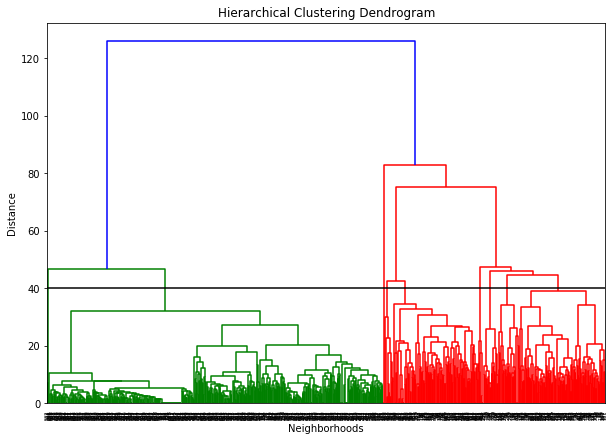

In [224]:
import scipy.cluster.hierarchy as shc

data = allvenues_grouped.iloc[:,6:]
plt.figure(figsize=(10, 7))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=40, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward')) 


## According to the above graph, I decide to separate our neighborhoods into nine clusters (cut at distance of 40, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods. 

In [225]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)  

In [226]:
allvenues_sorted['Cluster_Labels'] = clusterresult

In [227]:
# Define a function to show the neighborhoods with same cluster labels
def clustermap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    colnum = 9
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map

    for lat, lon, neighborhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                               dataframe['Longitude'], 
                                                               dataframe['NeighborhoodName'], 
                                                               dataframe['Borough'],
                                                               dataframe['Cluster_Labels']):
        cluster = cluster_labels 
        label = '{}, {},Cluster:{}'.format(neighborhood, borough,cluster_labels)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

## Total number of neighborhoods in each cluster


In [228]:
for ii in range(9):
    num = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == ii].shape[0]
    print('Total number of neighborhoods in cluster {} is {}'.format(ii, num))

Total number of neighborhoods in cluster 0 is 122
Total number of neighborhoods in cluster 1 is 121
Total number of neighborhoods in cluster 2 is 21
Total number of neighborhoods in cluster 3 is 31
Total number of neighborhoods in cluster 4 is 8
Total number of neighborhoods in cluster 5 is 2
Total number of neighborhoods in cluster 6 is 2
Total number of neighborhoods in cluster 7 is 478
Total number of neighborhoods in cluster 8 is 13


## Cluster 5 and 6 only has only 2 neighborhoods. These two clusters probably just contain the outliers. So let's look at cluster 5 and 6 first.

In [229]:
# cluster 5
allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 5]

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
115,New York,Manhattan,Murray Hill,40.7483,-73.9783,155,Korean Restaurant,Pizza Place,Bakery,Sandwich Place,Grocery Store,Deli / Bodega,Karaoke Bar,Gourmet Shop,Supermarket,American Restaurant,5
180,New York,Queens,Murray Hill,40.7641,-73.8128,155,Korean Restaurant,Pizza Place,Bakery,Sandwich Place,Grocery Store,Deli / Bodega,Karaoke Bar,Gourmet Shop,Supermarket,American Restaurant,5


In [230]:
# cluster 6
allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 6]

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
532,Beijing,Dongcheng,Jingshan,39.9221,116.396,39,Historic Site,French Restaurant,Scenic Lookout,Park,Vietnamese Restaurant,Lounge,Noodle House,Garden,Bookstore,History Museum,6
533,Beijing,Dongcheng,Donghuamen,39.9138,116.395,58,Historic Site,Park,Pizza Place,Clothing Store,Scenic Lookout,Dessert Shop,Lounge,Concert Hall,Plaza,Garden,6


##  Cluster 5 is the same neighborhood throughout two boroughs, which is also unique in New York. Cluster 6 is the historical area of Beijing, thus no similar area is found in other cities.

## Let's look at other neighborhood clusters.

------

## Cluster 0

In [231]:
cluster0 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 0]
cluster0

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
1,New York,Bronx,Co-op City,40.8743,-73.8299,62,Mobile Phone Shop,Pizza Place,Department Store,Shoe Store,Miscellaneous Shop,Discount Store,Restaurant,Furniture / Home Store,Bakery,Accessories Store,0
6,New York,Manhattan,Marble Hill,40.8766,-73.9107,66,Park,Mexican Restaurant,Supermarket,Spanish Restaurant,Pharmacy,Pizza Place,Donut Shop,Scenic Lookout,Bank,Bakery,0
7,New York,Bronx,Woodlawn,40.8983,-73.8673,42,Pub,Deli / Bodega,Discount Store,Pizza Place,Rental Car Location,Bakery,Pharmacy,Donut Shop,Italian Restaurant,American Restaurant,0
8,New York,Bronx,Norwood,40.8772,-73.8794,67,Pizza Place,Donut Shop,Fast Food Restaurant,Mexican Restaurant,Supermarket,Deli / Bodega,Pharmacy,Park,Bank,Caribbean Restaurant,0
10,New York,Bronx,Baychester,40.8669,-73.8358,83,Clothing Store,Department Store,Pharmacy,Sandwich Place,Discount Store,Supermarket,Pizza Place,Deli / Bodega,Bakery,Spanish Restaurant,0
14,New York,Bronx,University Heights,40.8557,-73.9104,57,Grocery Store,Pizza Place,Bakery,Spanish Restaurant,Donut Shop,Shoe Store,Supermarket,Restaurant,Latin American Restaurant,Fast Food Restaurant,0
15,New York,Bronx,Morris Heights,40.8479,-73.9197,49,Pizza Place,Fried Chicken Joint,Supermarket,Spanish Restaurant,Deli / Bodega,Pharmacy,Grocery Store,Bank,Ice Cream Shop,Fast Food Restaurant,0
17,New York,Bronx,East Tremont,40.8427,-73.8874,64,Donut Shop,Park,Pizza Place,Fast Food Restaurant,Bank,Sandwich Place,Zoo Exhibit,Department Store,Mobile Phone Shop,Lounge,0
18,New York,Bronx,West Farms,40.8395,-73.8777,44,Park,Pizza Place,Donut Shop,Zoo,Fried Chicken Joint,Department Store,Fast Food Restaurant,Lounge,Zoo Exhibit,Sandwich Place,0
21,New York,Bronx,Mott Haven,40.8062,-73.9161,46,Pizza Place,Donut Shop,Mexican Restaurant,Discount Store,Supermarket,Fast Food Restaurant,Grocery Store,Burger Joint,Park,Brewery,0


In [232]:
clustermap('New York','USA',cluster0[cluster0['City'] == 'New York'])

In [233]:
clustermap('Toronto','Canada',cluster0[cluster0['City'] == 'Toronto'])

## Cluster 0 contains the neighborhoods in New York and Toronto. The New York region consists a wide range of local business like restaurants and pizza shops. As for Toronto, the neighbourhood primarly constitutes shopping centers. 

------

## Cluster 1

In [235]:
cluster1 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 1]
cluster1

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
4,New York,Bronx,Riverdale,40.8908,-73.9126,104,Park,Bakery,Vietnamese Restaurant,Pizza Place,Diner,Bank,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Plaza,1
12,New York,Bronx,City Island,40.8472,-73.7865,37,Harbor / Marina,Seafood Restaurant,Italian Restaurant,Boat or Ferry,Park,American Restaurant,Theater,History Museum,Grocery Store,Music Venue,1
46,New York,Brooklyn,Bay Ridge,40.6258,-74.0306,83,Pizza Place,Spa,Italian Restaurant,Greek Restaurant,American Restaurant,Bagel Shop,Cosmetics Shop,Diner,Bakery,Grocery Store,1
49,New York,Brooklyn,Greenpoint,40.7302,-73.9542,67,Pizza Place,Bakery,Record Shop,Mexican Restaurant,Sandwich Place,Yoga Studio,Polish Restaurant,Italian Restaurant,Furniture / Home Store,New American Restaurant,1
52,New York,Brooklyn,Sheepshead Bay,40.5869,-73.9432,86,Russian Restaurant,Italian Restaurant,Japanese Restaurant,Sandwich Place,Pizza Place,Turkish Restaurant,Restaurant,Dessert Shop,Mobile Phone Shop,Seafood Restaurant,1
58,New York,Brooklyn,Windsor Terrace,40.6569,-73.9801,68,Park,Italian Restaurant,Diner,Deli / Bodega,Plaza,American Restaurant,Pizza Place,Middle Eastern Restaurant,Bookstore,Bagel Shop,1
59,New York,Brooklyn,Prospect Heights,40.6768,-73.9649,71,Thai Restaurant,Plaza,Pizza Place,New American Restaurant,Gourmet Shop,Mexican Restaurant,American Restaurant,Bakery,Yoga Studio,Ice Cream Shop,1
61,New York,Brooklyn,Williamsburg,40.7071,-73.9581,69,Pizza Place,American Restaurant,Breakfast Spot,Seafood Restaurant,Japanese Restaurant,Mexican Restaurant,BBQ Joint,South American Restaurant,Burger Joint,Music Store,1
64,New York,Brooklyn,Brooklyn Heights,40.6959,-73.9938,72,Park,Yoga Studio,Italian Restaurant,Pizza Place,Grocery Store,Burger Joint,History Museum,American Restaurant,Ice Cream Shop,Cosmetics Shop,1
65,New York,Brooklyn,Cobble Hill,40.6879,-73.9986,72,Italian Restaurant,Bakery,Pizza Place,Ice Cream Shop,Yoga Studio,Bagel Shop,Bookstore,Gourmet Shop,Gift Shop,Park,1


In [236]:
clustermap('New York','USA',cluster1[cluster1['City'] == 'New York'])

In [237]:
clustermap('Toronto','Canada',cluster1[cluster1['City'] == 'Toronto'])

In [258]:
clustermap('Shanghai','China',cluster1[cluster1['City'] == 'Shanghai'])

In [259]:
clustermap('Beijing','China',cluster1[cluster1['City'] == 'Beijing'])

## Cluster 1 is basically the city center where surrounded by a variety of venues, including theaters, parks, restaurants and bars.

## cluster 2

In [238]:
cluster2 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 2]
cluster2

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,New York,Bronx,Wakefield,40.8947,-73.8472,39,Pharmacy,Caribbean Restaurant,Donut Shop,Fast Food Restaurant,Supermarket,Sandwich Place,Pizza Place,Southern / Soul Food Restaurant,Mobile Phone Shop,Spanish Restaurant,2
2,New York,Bronx,Eastchester,40.8876,-73.8278,50,Caribbean Restaurant,Fast Food Restaurant,Pizza Place,Diner,Donut Shop,Grocery Store,Burger Joint,Supplement Shop,Asian Restaurant,Sandwich Place,2
9,New York,Bronx,Williamsbridge,40.881,-73.8574,63,Pizza Place,Caribbean Restaurant,Bakery,Fried Chicken Joint,Deli / Bodega,Fast Food Restaurant,Pharmacy,Discount Store,Supermarket,Cosmetics Shop,2
45,New York,Bronx,Edenwald,40.8846,-73.8481,40,Supermarket,Fast Food Restaurant,Caribbean Restaurant,Pizza Place,Fried Chicken Joint,Pharmacy,Grocery Store,Donut Shop,Mobile Phone Shop,Ice Cream Shop,2
54,New York,Brooklyn,Flatbush,40.6363,-73.9584,80,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pharmacy,Ice Cream Shop,Mobile Phone Shop,Health Food Store,Lounge,Sandwich Place,2
55,New York,Brooklyn,Crown Heights,40.6708,-73.9433,76,Caribbean Restaurant,Pizza Place,Grocery Store,Bakery,Deli / Bodega,Bagel Shop,Lounge,Convenience Store,Playground,Japanese Restaurant,2
56,New York,Brooklyn,East Flatbush,40.6417,-73.9361,32,Caribbean Restaurant,Deli / Bodega,Discount Store,Lounge,Grocery Store,Park,Music Venue,Nightclub,Furniture / Home Store,Check Cashing Service,2
63,New York,Brooklyn,Bedford Stuyvesant,40.6872,-73.9418,57,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Juice Bar,Deli / Bodega,Garden,Thrift / Vintage Store,Taco Place,Playground,Fried Chicken Joint,2
74,New York,Brooklyn,Canarsie,40.6356,-73.9021,25,Caribbean Restaurant,Pizza Place,Bank,Pharmacy,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Ice Cream Shop,Bagel Shop,Shop & Service,2
75,New York,Brooklyn,Flatlands,40.6304,-73.9291,56,Caribbean Restaurant,Pizza Place,Discount Store,Mobile Phone Shop,Park,Pharmacy,Fast Food Restaurant,Supermarket,Lounge,Miscellaneous Shop,2


In [239]:
clustermap('New York','USA',cluster2[cluster2['City'] == 'New York'])

## Cluster 2: Neighborhoods in New York with a lot of nearby pizza places, fast food restaurants and Caribbean restaurants.

-----

## cluster 3

In [241]:
cluster3 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 3]
cluster3

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
5,New York,Bronx,Kingsbridge,40.8817,-73.9028,81,Pizza Place,Mexican Restaurant,Diner,Sandwich Place,Donut Shop,Supermarket,Pharmacy,Bank,Latin American Restaurant,Trail,3
11,New York,Bronx,Pelham Parkway,40.8574,-73.8548,51,Pizza Place,Donut Shop,Deli / Bodega,Sandwich Place,Italian Restaurant,Bakery,Pharmacy,Bank,Supermarket,Ice Cream Shop,3
13,New York,Bronx,Bedford Park,40.8702,-73.8855,114,Pizza Place,Park,Sandwich Place,Diner,Pharmacy,Bakery,Japanese Restaurant,Deli / Bodega,Fast Food Restaurant,Supermarket,3
16,New York,Bronx,Fordham,40.861,-73.8964,87,Italian Restaurant,Pizza Place,Spanish Restaurant,Shoe Store,Diner,Supplement Shop,Dessert Shop,Park,Pharmacy,Deli / Bodega,3
20,New York,Bronx,Melrose,40.8198,-73.9094,80,Pizza Place,Mexican Restaurant,Donut Shop,Discount Store,Supermarket,Pharmacy,Fried Chicken Joint,Mobile Phone Shop,Sandwich Place,Diner,3
30,New York,Bronx,Parkchester,40.8379,-73.856,87,Pizza Place,Sandwich Place,Spanish Restaurant,Supermarket,Latin American Restaurant,Bank,Donut Shop,Grocery Store,Diner,Caribbean Restaurant,3
33,New York,Bronx,Morris Park,40.8475,-73.8504,79,Pizza Place,Italian Restaurant,Pharmacy,Sandwich Place,Donut Shop,Bank,Supermarket,Spanish Restaurant,Deli / Bodega,Shoe Store,3
34,New York,Bronx,Belmont,40.8573,-73.8885,88,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Diner,Botanical Garden,Dessert Shop,Zoo,Plaza,Garden,3
44,New York,Bronx,Unionport,40.8298,-73.8505,86,Pizza Place,Supermarket,Diner,Cosmetics Shop,Sandwich Place,Fast Food Restaurant,Spanish Restaurant,Mobile Phone Shop,Deli / Bodega,Clothing Store,3
48,New York,Brooklyn,Sunset Park,40.6451,-74.0103,82,Mexican Restaurant,Bakery,Pizza Place,Bank,Latin American Restaurant,Tea Room,Vietnamese Restaurant,Sandwich Place,Asian Restaurant,Ice Cream Shop,3


In [242]:
clustermap('New York','USA',cluster3[cluster3['City'] == 'New York'])

In [243]:
clustermap('Toronto','Canada',cluster3[cluster3['City'] == 'Toronto'])

## Cluster 3: Most are New York and Toronto neighborhoods with a lot of Italian and pizza places.

In [244]:
## cluster 4
cluster4 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 4]
cluster4

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
138,New York,Queens,Flushing,40.7645,-73.8318,58,Bubble Tea Shop,Korean Restaurant,Bakery,Karaoke Bar,Pizza Place,Ice Cream Shop,Dessert Shop,Tea Room,Asian Restaurant,Supermarket,4
152,New York,Queens,Auburndale,40.7617,-73.7918,87,Korean Restaurant,Greek Restaurant,Pizza Place,Cosmetics Shop,Bank,Ice Cream Shop,Mobile Phone Shop,Pharmacy,Asian Restaurant,American Restaurant,4
353,Toronto,North York,Fairview,43.7709,-79.4124,72,Korean Restaurant,Pizza Place,Bubble Tea Shop,Dessert Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Pharmacy,Sandwich Place,Fried Chicken Joint,4
385,Toronto,North York,Newtonbrook,43.7939,-79.4257,56,Korean Restaurant,Middle Eastern Restaurant,Pizza Place,Sandwich Place,Grocery Store,Vietnamese Restaurant,Indian Restaurant,Fast Food Restaurant,Bank,Dessert Shop,4
386,Toronto,North York,Willowdale,43.7698,-79.4138,70,Korean Restaurant,Pizza Place,Bubble Tea Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Restaurant,Sandwich Place,Fried Chicken Joint,Wings Joint,4
397,Toronto,North York,Willowdale South,43.7698,-79.4138,70,Korean Restaurant,Pizza Place,Bubble Tea Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Restaurant,Sandwich Place,Fried Chicken Joint,Wings Joint,4
416,Toronto,North York,Willowdale West,43.7698,-79.4138,70,Korean Restaurant,Pizza Place,Bubble Tea Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Restaurant,Sandwich Place,Fried Chicken Joint,Wings Joint,4
503,Beijing,Chaoyang,Wangjing,39.9919,116.46,26,Korean Restaurant,Fast Food Restaurant,Bakery,Shop & Service,Noodle House,Movie Theater,Pizza Place,Wings Joint,Convenience Store,Spa,4


In [245]:
clustermap('New York','USA',cluster4[cluster4['City'] == 'New York'])

In [246]:
clustermap('Toronto','Canada',cluster4[cluster4['City'] == 'Toronto'])

In [247]:
clustermap('Beijing','China',cluster4[cluster4['City'] == 'Beijing'])

## Cluster 4 includes the neighborhoods in New York, Toronto and Beijing. These neighborhoods have a lot of dining place with Korean cuisine.

## cluster 7


In [248]:
## cluster 7
cluster7 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 7]
cluster7

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
3,New York,Bronx,Fieldston,40.8954,-73.9056,32,Pizza Place,Mexican Restaurant,Plaza,Sandwich Place,Historic Site,Bakery,Bank,Home Service,Playground,Garden,7
19,New York,Bronx,High Bridge,40.8366,-73.9261,31,Baseball Field,Lounge,Smoke Shop,Plaza,Sandwich Place,Seafood Restaurant,Historic Site,Hobby Shop,Snack Place,Steakhouse,7
22,New York,Bronx,Port Morris,40.8017,-73.9132,24,Donut Shop,Pizza Place,Cupcake Shop,Deli / Bodega,Furniture / Home Store,Burger Joint,Brewery,Grocery Store,Performing Arts Venue,Tunnel,7
24,New York,Bronx,Hunts Point,40.8097,-73.8833,20,Construction & Landscaping,Park,Seafood Restaurant,Market,Grocery Store,Fast Food Restaurant,Pool,Waste Facility,Bank,Bakery,7
27,New York,Bronx,Clason Point,40.8066,-73.8541,4,Park,Discount Store,South American Restaurant,Chinese Restaurant,Football Stadium,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,7
42,New York,Bronx,Pelham Gardens,40.863,-73.8416,34,Sandwich Place,Donut Shop,Pharmacy,Caribbean Restaurant,Deli / Bodega,Pizza Place,Bakery,Bank,Historic Site,Music Venue,7
72,New York,Brooklyn,East New York,40.6699,-73.8807,22,Sandwich Place,Pizza Place,Pharmacy,Supermarket,Grocery Store,Yoga Studio,Discount Store,Donut Shop,Playground,Spanish Restaurant,7
76,New York,Brooklyn,Mill Island,40.6063,-73.9082,18,Harbor / Marina,Pizza Place,Burger Joint,Park,Stables,Middle Eastern Restaurant,Boat or Ferry,Pool,Bakery,BBQ Joint,7
85,New York,Brooklyn,Sea Gate,40.5764,-74.0079,14,Beach,Pharmacy,Business Service,American Restaurant,Spa,Home Service,Supermarket,Park,Donut Shop,Convenience Store,7
91,New York,Brooklyn,Bergen Beach,40.6151,-73.8986,8,Donut Shop,Deli / Bodega,Italian Restaurant,Pizza Place,Supermarket,Peruvian Restaurant,Stables,Frozen Yogurt Shop,Fish & Chips Shop,Farmers Market,7


In [249]:
clustermap('New York','USA',cluster7[cluster7['City'] == 'New York'])

In [250]:
clustermap('Toronto','Canada',cluster7[cluster7['City'] == 'Toronto'])

In [251]:
clustermap('Beijing','China',cluster7[cluster7['City'] == 'Beijing'])

In [252]:
clustermap('Shanghai','China',cluster7[cluster7['City'] == 'Shanghai'])

## Cluster 7 is basically the city center where surrounded by a variety of venues, including theaters, parks, restaurants and bars.

## cluster 8

In [253]:
## cluster 8
cluster8 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 8]
cluster8

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
169,New York,Queens,Rosedale,40.6598,-73.7353,116,Caribbean Restaurant,Clothing Store,Furniture / Home Store,Restaurant,Cosmetics Shop,American Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Gastropub,8
315,Toronto,Downtown Toronto,Ryerson,43.6582,-79.3791,78,Clothing Store,Tea Room,Restaurant,Pizza Place,Italian Restaurant,Plaza,Gastropub,Thai Restaurant,Theater,Burger Joint,8
316,Toronto,Downtown Toronto,Garden District,43.6603,-79.376,73,Gastropub,Theater,Diner,Restaurant,Steakhouse,Clothing Store,Bookstore,Falafel Restaurant,Tea Room,Pub,8
329,Toronto,Downtown Toronto,St. James Town,43.6626,-79.3764,144,Gastropub,Diner,Gay Bar,Burger Joint,Men's Store,Pub,Dance Studio,Pizza Place,Falafel Restaurant,Park,8
340,Toronto,Downtown Toronto,Central Bay Street,43.6604,-79.3856,74,Bubble Tea Shop,Tea Room,Burger Joint,Pizza Place,Gastropub,Japanese Restaurant,Diner,Thai Restaurant,Gay Bar,Italian Restaurant,8
341,Toronto,Downtown Toronto,Christie,43.65,-79.3857,69,American Restaurant,Restaurant,Japanese Restaurant,Theater,Italian Restaurant,Asian Restaurant,Pizza Place,Concert Hall,Steakhouse,Pub,8
348,Toronto,Downtown Toronto,King,43.6548,-79.3801,74,Clothing Store,Italian Restaurant,Gastropub,Restaurant,American Restaurant,Steakhouse,Cosmetics Shop,Concert Hall,Tea Room,Plaza,8
349,Toronto,Downtown Toronto,Richmond,43.6502,-79.3857,69,American Restaurant,Japanese Restaurant,Restaurant,Theater,Gastropub,Cosmetics Shop,Steakhouse,Pub,Movie Theater,Asian Restaurant,8
359,Toronto,Downtown Toronto,Union Station,43.6615,-79.3829,78,Burger Joint,Pizza Place,Japanese Restaurant,Diner,Bubble Tea Shop,Gastropub,Steakhouse,Dance Studio,Tea Room,Sandwich Place,8
454,Toronto,Downtown Toronto,Rosedale,43.6563,-79.3809,116,Caribbean Restaurant,Clothing Store,Furniture / Home Store,Restaurant,Cosmetics Shop,American Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Gastropub,8


In [254]:
clustermap('New York','USA',cluster8[cluster8['City'] == 'New York'])

In [255]:
clustermap('Toronto','Canada',cluster8[cluster8['City'] == 'Toronto'])

## Cluster 8 contains primarly Downtown Toronoto neighborhoods with access to varous venues like restaurants and shopping centers.





## Please note that it doesn't mean Beijing and Shanghai are less bustling. In fact, Beijing and Shanghai have even larger density of population. I think this is because the venue information provider Foursquare is located in USA, thus New York and Toronto has much more information than Beijing and Shanghai. Some venue providers located in China may help to have a more detailed analysis.

## Anyhow, I hope I convince you that despite the distinct cultural and geographical location differences of New York, Toronto, Beijing and Shanghai, there are several similar neighborhoods in cluster 1, 2, 3, 4, 7 and 8. I hope this could provide some useful information for peple who are considering moving among Canada, USA and China.

-----

## Conslusion

## Cluster 7 neighbourhoods provide details of ideal locations for residential living condition since it provides good balance to key venue categories like park, department stores, restaurants and access to public transportation. 

## Thank you for reading!